In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

# 检查是否有可用的 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:

# 5. 数据预处理和加载
def load_data():
    transform = transforms.ToTensor()
    train_data = datasets.MNIST(root='data', train=True, transform=transform, download=True)
    test_data = datasets.MNIST(root='data', train=False, transform=transform, download=True)
    combined_dataset = ConcatDataset([train_data, test_data])
    combined_loader = DataLoader(
        dataset=combined_dataset,
        batch_size=256,
        shuffle=True
    )
    print(f"Combined dataset size: {len(combined_dataset)}")
    return combined_loader


In [4]:
# 1. 定义 VAE 模型
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)
        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z).view(-1, 64, 7, 7)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [5]:

# 2. 定义损失函数
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [6]:
# 3. 训练函数
def train_vae(model, train_loader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        train_loss = 0
        for x, _ in progress_bar:
            x = x.to(device)
            optimizer.zero_grad()
            recon_x, mu, logvar = model(x)
            loss = vae_loss(recon_x, x, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item() / len(x))
        print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}")


In [7]:
# 4. 采样并展示图像
@torch.no_grad()
def sample_and_display_vae(model, latent_dim=20, num_samples=10):
    model.eval()
    z = torch.randn(num_samples, latent_dim).to(device)
    samples = model.decode(z).cpu()
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i].squeeze(0), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


Combined dataset size: 70000


Epoch 1/20: 100%|██████████| 274/274 [00:05<00:00, 50.95it/s, loss=130]


Epoch 1, Loss: 186.1591


Epoch 2/20: 100%|██████████| 274/274 [00:05<00:00, 53.44it/s, loss=119]


Epoch 2, Loss: 123.8243


Epoch 3/20: 100%|██████████| 274/274 [00:05<00:00, 47.48it/s, loss=111]


Epoch 3, Loss: 117.0893


Epoch 4/20: 100%|██████████| 274/274 [00:05<00:00, 48.89it/s, loss=107]


Epoch 4, Loss: 112.8705


Epoch 5/20: 100%|██████████| 274/274 [00:05<00:00, 50.15it/s, loss=111]


Epoch 5, Loss: 110.2929


Epoch 6/20: 100%|██████████| 274/274 [00:06<00:00, 43.21it/s, loss=103]


Epoch 6, Loss: 108.6770


Epoch 7/20: 100%|██████████| 274/274 [00:06<00:00, 44.45it/s, loss=106]


Epoch 7, Loss: 107.5561


Epoch 8/20: 100%|██████████| 274/274 [00:05<00:00, 50.86it/s, loss=106]


Epoch 8, Loss: 106.8032


Epoch 9/20: 100%|██████████| 274/274 [00:05<00:00, 50.54it/s, loss=105]


Epoch 9, Loss: 106.1319


Epoch 10/20: 100%|██████████| 274/274 [00:05<00:00, 54.74it/s, loss=105]


Epoch 10, Loss: 105.6637


Epoch 11/20: 100%|██████████| 274/274 [00:05<00:00, 51.17it/s, loss=104]


Epoch 11, Loss: 105.2653


Epoch 12/20: 100%|██████████| 274/274 [00:05<00:00, 53.21it/s, loss=105]


Epoch 12, Loss: 104.9414


Epoch 13/20: 100%|██████████| 274/274 [00:04<00:00, 54.96it/s, loss=106] 


Epoch 13, Loss: 104.5992


Epoch 14/20: 100%|██████████| 274/274 [00:04<00:00, 54.96it/s, loss=104] 


Epoch 14, Loss: 104.3716


Epoch 15/20: 100%|██████████| 274/274 [00:04<00:00, 59.26it/s, loss=108] 


Epoch 15, Loss: 104.1121


Epoch 16/20: 100%|██████████| 274/274 [00:04<00:00, 57.85it/s, loss=102] 


Epoch 16, Loss: 103.8636


Epoch 17/20: 100%|██████████| 274/274 [00:04<00:00, 55.74it/s, loss=100] 


Epoch 17, Loss: 103.6721


Epoch 18/20: 100%|██████████| 274/274 [00:05<00:00, 49.78it/s, loss=102] 


Epoch 18, Loss: 103.5010


Epoch 19/20: 100%|██████████| 274/274 [00:05<00:00, 50.26it/s, loss=103] 


Epoch 19, Loss: 103.2768


Epoch 20/20: 100%|██████████| 274/274 [00:05<00:00, 47.09it/s, loss=105] 


Epoch 20, Loss: 103.0582


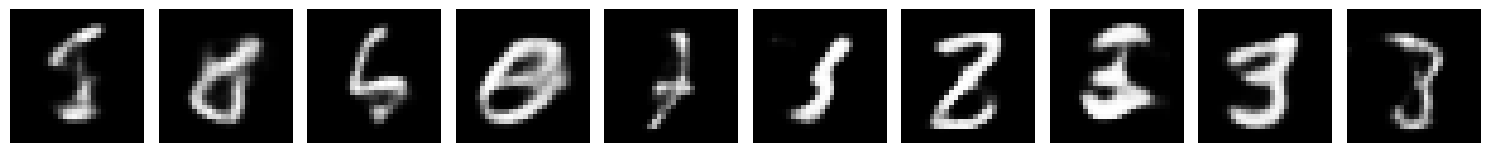

In [8]:
# 使用方式
train_loader = load_data()

# 6. 初始化模型和优化器
latent_dim = 20
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 7. 训练模型
train_vae(model, train_loader, optimizer, epochs=20)

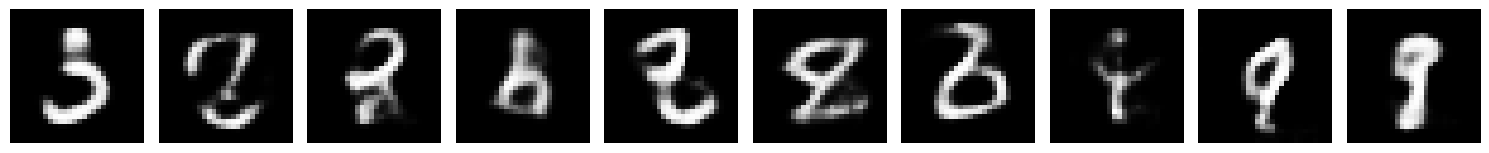

In [9]:
# 8. 使用 VAE 生成并展示样本
sample_and_display_vae(model, latent_dim=latent_dim, num_samples=10)